# Modeling

In [1]:
import warnings
from warnings import catch_warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import mean_squared_error

In [2]:
# Set the file paths.
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
raw_path = path + '/data/raw/'
processed_path = path + '/data/processed/'

In [3]:
# Pull in the data.
df_uber = pd.read_csv(processed_path + 'uber.csv')

# Set the 'date' field type.
df_uber.date = pd.to_datetime(df_uber.date)

# Verify the data.
df_uber.head()

,sourceid,dstid,mean_travel_time,time_of_week,date,trip
0,191,46,2021.00,weekdays,2016-02-01,191-46
1,168,42,1528.99,weekdays,2016-02-01,168-42
2,203,3,836.38,weekdays,2016-03-01,203-3
3,192,36,1752.46,weekdays,2016-02-01,192-36
4,218,8,1118.07,weekdays,2016-02-01,218-8


In [4]:
# Create separate dataframes based on the 'time_of_week' (weekdays/weekends).
df_wd = df_uber[df_uber['time_of_week'] != 'weekends']
df_we = df_uber[df_uber['time_of_week'] != 'weekdays']

In [5]:
df_wd.head()

,sourceid,dstid,mean_travel_time,time_of_week,date,trip
0,191,46,2021.00,weekdays,2016-02-01,191-46
1,168,42,1528.99,weekdays,2016-02-01,168-42
2,203,3,836.38,weekdays,2016-03-01,203-3
3,192,36,1752.46,weekdays,2016-02-01,192-36
4,218,8,1118.07,weekdays,2016-02-01,218-8


In [6]:
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440174 entries, 0 to 2779524
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   sourceid          1440174 non-null  int64         
 1   dstid             1440174 non-null  int64         
 2   mean_travel_time  1440174 non-null  float64       
 3   time_of_week      1440174 non-null  object        
 4   date              1440174 non-null  datetime64[ns]
 5   trip              1440174 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 76.9+ MB


In [7]:
# Group the dataframes by 'date', averaging the travel time.
df_wd = df_wd[['date', 'mean_travel_time']]
df_wd = df_wd.groupby('date').mean()

df_we = df_we[['date', 'mean_travel_time']]
df_we = df_we.groupby('date').mean()

# SARIMA

### Seasonal AutoRegressive Integrated Moving Average



# First Model

The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.  

"d" must be an integer indicating the integration order of the process, while "p" and "q" may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.  

Default is an AR(1) model: (1,0,0).

In [8]:
# Create and fit the basic model.
mod = SARIMAX(df_wd.mean_travel_time,
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.004    245.472      0.000       0.992       1.008
sigma2      1026.3712    258.259      3.974      0.000     520.192    1532.550


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


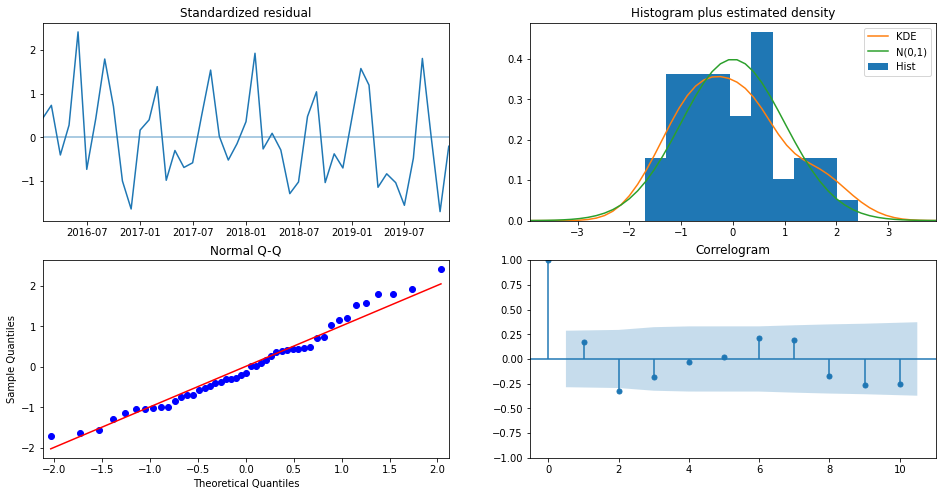

In [9]:
# Plot the diagnostics.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

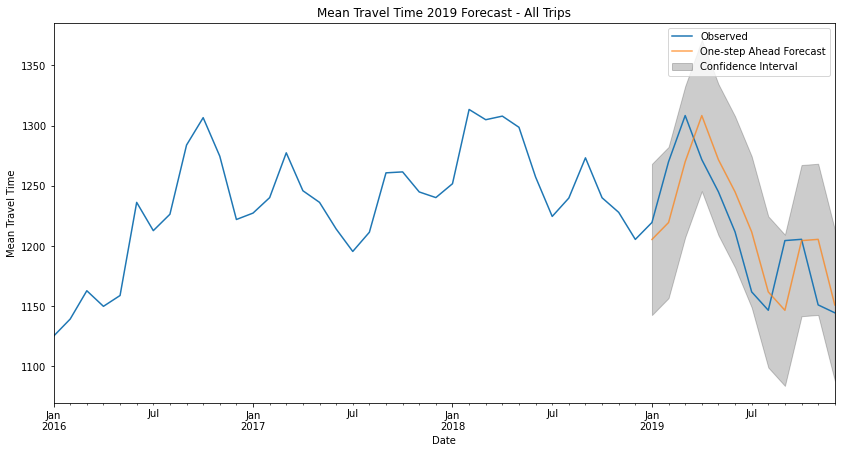

In [12]:
# Plot the predictions.
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)

pred_ci = pred.conf_int()

ax = df_wd.mean_travel_time['2016':].plot(label='Observed')

pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='k',
                label='Confidence Interval',
                alpha=.2)

ax.set_title('Mean Travel Time 2019 Forecast - All Trips')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Travel Time')
plt.legend()
plt.show()

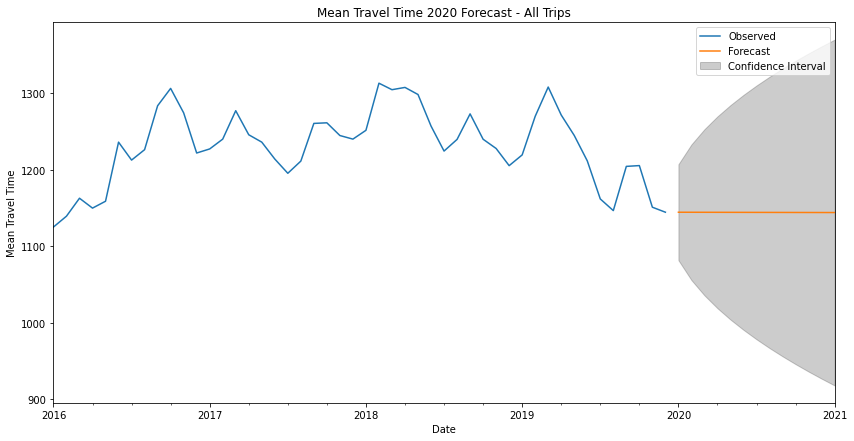

In [13]:
# Plot the forecast.
pred_uc = results.get_forecast(steps=13)
pred_ci = pred_uc.conf_int()
ax = df_wd.mean_travel_time.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='k',
                label='Confidence Interval',
                alpha=.2)
ax.set_title('Mean Travel Time 2020 Forecast - All Trips')
ax.set_xlabel('Date')
ax.set_ylabel('Mean Travel Time')
plt.legend()
plt.show()

In [14]:
# Calculate the RMSE
y_forecasted = pred.predicted_mean
y_truth = df_wd.mean_travel_time['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print('The Root Mean Squared Error of the forecasts is ' + str(rmse))

The Root Mean Squared Error of the forecasts is 37.02


---

# Adding Seasonal Order to the model  

#### From statsmodels.org:
The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.  

"D" must be an integer indicating the integration order of the process, while "P" and "Q" may either be an integers indicating the AR and MA
orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include.  

"s" is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

In [13]:
mod = SARIMAX(df_wd.mean_travel_time,
              order=(1, 0, 0),
              seasonal_order=(1, 0, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit()

pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)

y_forecasted = pred.predicted_mean
y_truth = df_wd.mean_travel_time['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
rmse = round(np.sqrt(mse), 2)
print('The Root Mean Squared Error of the forecasts is ' + str(rmse))

The Root Mean Squared Error of the forecasts is 28.7


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


### The RMSE is lower (28.7 vs 37) after adding in seasonality order.

---

## Finding the optimum parameters to minimize Root Mean Square Error

The following example was pulled and modified from [here](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/).

In [14]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder= config
    # define the model
    model = SARIMAX(history, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # Hide warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    return (key, result)

# grid search configs
def grid_search(data, parallel=True):
    
    # data split
    n_test = 12
    
    # model configs
    cfg_list = sarima_configs()
    
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs():
    models = []
    # define config lists
    p_params = [0, 1] #[0, 1, 2]
    d_params = [0, 1] #[0, 1]
    q_params = [0, 1] #[0, 1, 2]
    P_params = [0, 1] #[0, 1, 2]
    D_params = [0, 1] #[0, 1]
    Q_params = [0, 1] #[0, 1, 2]
    #m_params = seasonal
    m = 12
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            cfg = [(p,d,q), (P,D,Q,m)]
                            models.append(cfg)
                            
    return models

def get_params(data):
    # grid search
    scores = grid_search(data.values)

    # list top configs
    for cfg, error in scores[:1]:
        # Store the order and seasonal order from the config with the lowest RMSE in the 'params' list.
        params = [[int(cfg[2]), int(cfg[5]), int(cfg[8])], [int(cfg[13]), int(cfg[16]), int(cfg[19]), int(cfg[22] + cfg[23])]]
        err = error
    return params

In [17]:
def forecast_time(data):
    # Call the get_params function to return the parameters for the SARIMAX model with the lowest Root Mean Square Error.
    params = get_params(data)
    
    # Generate a model using the parameters stored in 'params'.
    mod = SARIMAX(data.mean_travel_time,
                  order=params[0],
                  seasonal_order=params[1],
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    results = mod.fit()
    
    # Store the predictions for the year 2019.
    pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
    
    # Store the 95% Confidence Intervals for the predictions.
    pred_ci = pred.conf_int()
    
    y_forecasted = pred.predicted_mean
    y_truth = data.mean_travel_time['2019-01-01':]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(mse)
    #print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 2)))
    
    # Print the RMSE
    print('The Root Mean Squared Error of the One-Step Ahead Forecast is {}'.format(round(rmse, 2)))
    
    # Observed vs Forecast
    ax = data.mean_travel_time['2016':].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', label='Confidence Interval', alpha=.2)
    ax.set_title('Mean Travel Time 2019 Forecast - All Trips')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Travel Time [seconds]')
    plt.legend()
    plt.savefig(path + '/images/predicted.png')
    plt.show()
    
    # Store the forecasts for the year 2020.
    pred_uc = results.get_forecast(steps=13)
    
    # Store the 95% Confidence Intervals for the predictions.
    pred_ci = pred_uc.conf_int()
    
    forecast_list = []
    forecast_list = results.get_prediction(start=pd.to_datetime('2020-01-01'), end=pd.to_datetime('2020-12-01'), dynamic=False)
    forecast_list = forecast_list.predicted_mean
    
    
    ax = data.mean_travel_time.plot(label='Observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', label='Confidence Interval', alpha=.2)
    ax.set_title('Mean Travel Time 2020 Forecast - All Trips')
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean Travel Time [seconds]')
    plt.legend()
    plt.savefig(path + '/images/forecast.png')
    plt.show()
    
    # Return the list of forecasted travel times.
    print(forecast_list)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of the One-Step Ahead Forecast is 23.39


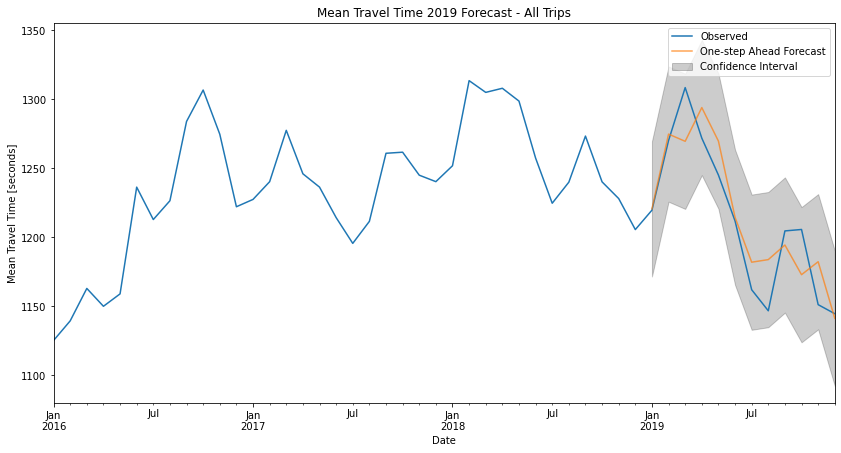

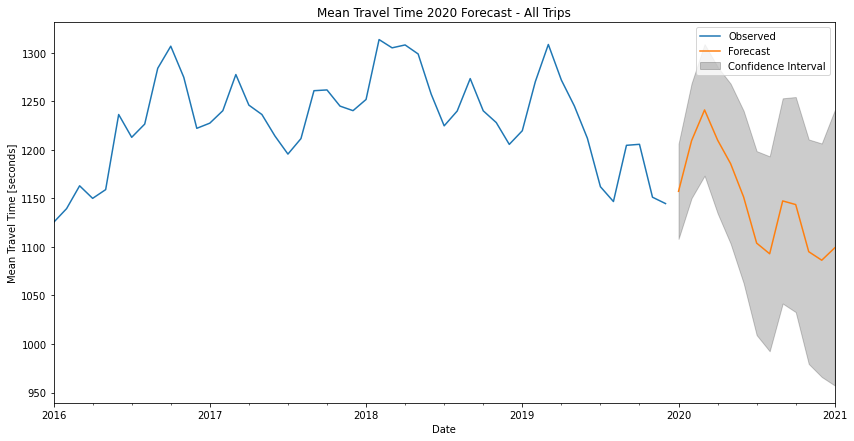

2020-01-01    1157.216105
2020-02-01    1209.275308
2020-03-01    1241.023138
2020-04-01    1209.963714
2020-05-01    1185.676397
2020-06-01    1151.313177
2020-07-01    1103.870112
2020-08-01    1092.897810
2020-09-01    1147.328124
2020-10-01    1143.567291
2020-11-01    1095.047162
2020-12-01    1086.269903
Freq: MS, dtype: float64


In [18]:
forecast_time(df_wd)

---

## Determine SARIMA Model Parameters for a subset of trips.

In [20]:
# Create a list that contains each of the trips starting in a central tract. In this example tract '7' was used.
# This will be used to subset the wd_df dataframe for building a model specific to the trip in question.
df_central = df_uber[(df_uber['sourceid'] == 7) & (df_uber['time_of_week'] == 'weekdays')]
trips = df_central.trip.unique()
trips

array(['7-237', '7-55', '7-7', '7-56', '7-156', '7-129', '7-193', '7-245',
       '7-182', '7-10', '7-146', '7-8', '7-183', '7-119', '7-46', '7-201',
       '7-166', '7-246', '7-64', '7-210', '7-137', '7-228', '7-111',
       '7-227', '7-36', '7-191', '7-229', '7-139', '7-165', '7-157',
       '7-47', '7-155', '7-209', '7-200', '7-54', '7-128', '7-65',
       '7-175', '7-147', '7-9', '7-148', '7-173', '7-174', '7-192',
       '7-219', '7-184', '7-120', '7-238', '7-45', '7-138', '7-164',
       '7-218', '7-167', '7-249', '7-67', '7-185', '7-121', '7-122',
       '7-211', '7-212', '7-177', '7-58', '7-49', '7-248', '7-186', '7-1',
       '7-57', '7-131', '7-168', '7-239', '7-130', '7-48', '7-221',
       '7-176', '7-11', '7-202', '7-158', '7-195', '7-230', '7-220',
       '7-194', '7-159', '7-140', '7-149', '7-113', '7-66', '7-203',
       '7-112', '7-240', '7-114', '7-214', '7-187', '7-31', '7-205',
       '7-132', '7-196', '7-213', '7-50', '7-3', '7-2', '7-142', '7-179',
       '7-105',

In [21]:
# Loop through the trips list and store the parameters and error for each trip in a dataframe.
df_temp = pd.DataFrame()
df_params = pd.DataFrame(columns=['trip', 'p', 'd', 'q', 'p_s', 'd_s', 'q_s', 's', 'error'])

for trip in trips:
    # Subset the df_wd dataframe based on the trip
    df_temp = df_central[df_central['trip'] == trip]
    
    # Drop irrelevant columns
    df_temp = df_temp[['date', 'mean_travel_time']]
    # 
    df_temp = df_temp.groupby('date').mean()

    # grid search
    scores = grid_search(df_temp.values)

    # list top configs
    for cfg, error in scores[:1]:
        p = int(cfg[2])
        d = int(cfg[5])
        q = int(cfg[8])
        p_s = int(cfg[13])
        d_s = int(cfg[16])
        q_s = int(cfg[19])
        s = int(cfg[22] + cfg[23])
        new_row = {'trip':trip, 'p':p, 'd':d, 'q':q, 'p_s':p_s, 'd_s':d_s, 'q_s':q_s, 's':s, 'error':error}
        df_params = df_params.append(new_row, ignore_index=True)

# Save the data to csv.
df_params.to_csv(processed_path + '/params.csv', index = False)

In [22]:
df_params

,trip,p,d,q,p_s,d_s,q_s,s,error
0,7-237,0,0,0,1,0,0,12,39.994989
1,7-55,1,0,1,0,1,0,12,17.282282
2,7-7,0,0,1,0,1,0,12,46.578668
3,7-56,0,0,0,1,1,0,12,9.759251
4,7-156,1,0,1,1,1,0,12,17.337683
...,...,...,...,...,...,...,...,...,...
173,7-217,0,0,0,1,1,0,12,30.938618
174,7-163,0,1,1,1,1,0,12,21.591341
175,7-154,1,1,1,1,0,0,12,8.505795
176,7-145,0,0,0,1,0,0,12,42.899327


In [23]:
df_params.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   trip    178 non-null    object 
 1   p       178 non-null    object 
 2   d       178 non-null    object 
 3   q       178 non-null    object 
 4   p_s     178 non-null    object 
 5   d_s     178 non-null    object 
 6   q_s     178 non-null    object 
 7   s       178 non-null    object 
 8   error   178 non-null    float64
dtypes: float64(1), object(8)
memory usage: 12.6+ KB


In [24]:
df_params.describe()

,error
count,178.000000
mean,24.165570
std,9.652524
min,5.321782
25%,16.932501
50%,23.687649
75%,30.992733
max,57.317778


The max Root Mean Square Error for this batch of trips is 57.3 seconds.